<a id='Title-ConvNet-Visualization'></a>
<h1 style="color:SlateGray;">ConvNet Visualization</h1>

<h2 style="color:SlateGray;">Background</h2>

**Pre-trained models**

[*VGG16*](08_Feature_Extraction.ipynb#Pre-trained-models-VGG16)

**Layers**

[*Conv2D*](06_Basic_ConvNet.ipynb#Layers-Conv2D)

<h2 style="color:SlateGray;">Overview</h2>

*Feature maps* and *gradient ascent in input space* allow for visualization of what a convNet learns from an image and what patterns are encoded in individual filters, respectively. *Grad-CAM* produces heatmaps of individual class activations on an input image giving a sense of how much that image activate the class, and where the activations take place in the image.

Feature maps are produced by inputing an image into the network and displaying the individual channels from each layer. Gradient ascent in input space iteratively maximizes activation responses from individual filters to produce an image of what the filter looks for. Grad-CAM takes the trained convolutional layers from a network and uses them to create a "new layer" with channel-wise scaled gradient values based on their importance to the class of interest.


In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.2'

In [25]:
from keras.models import load_model

model = load_model('cats_and_dogs_small_2.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [26]:
img_path = r'./cats_and_dogs_small/test/cats/cat.1700.jpg'

from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

print(img_tensor.shape)

(1, 150, 150, 3)


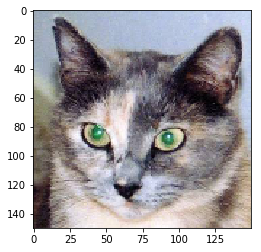

In [27]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [33]:
from keras import models

layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(img_tensor)

for i in range(len(activations)):
    layer_activation = activations[i]
    print(layer_activation.shape)

first_layer_activation = activations[0]

(1, 148, 148, 32)
(1, 74, 74, 32)
(1, 72, 72, 64)
(1, 36, 36, 64)
(1, 34, 34, 128)
(1, 17, 17, 128)
(1, 15, 15, 128)
(1, 7, 7, 128)


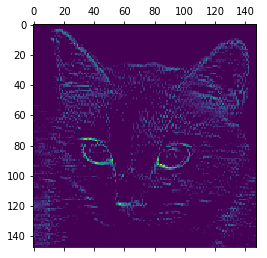

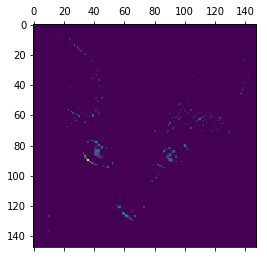

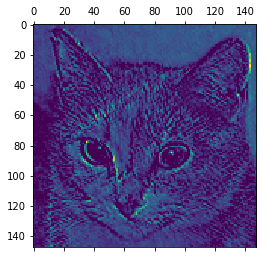

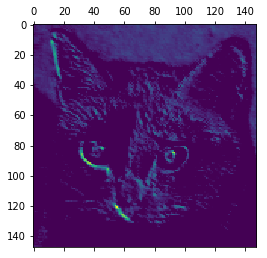

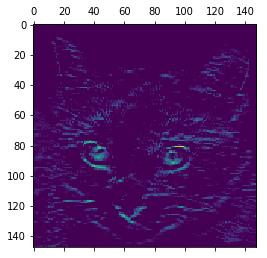

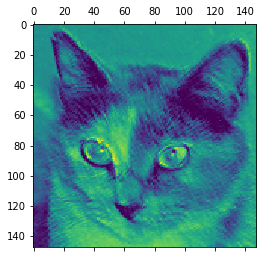

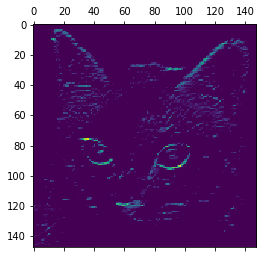

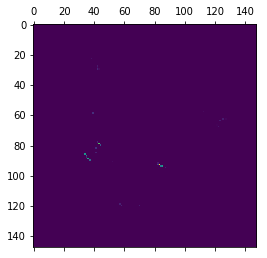

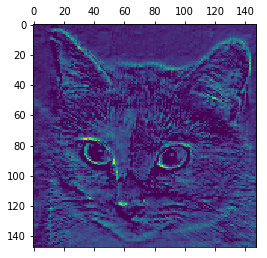

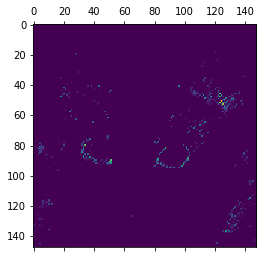

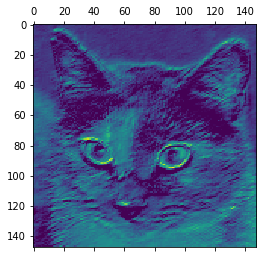

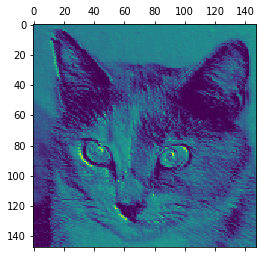

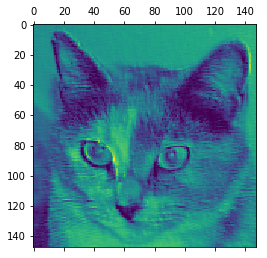

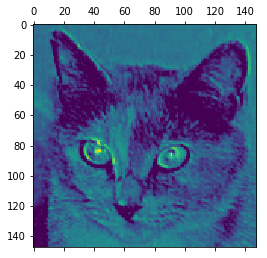

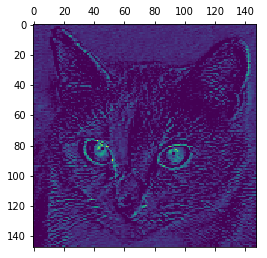

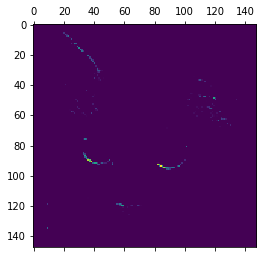

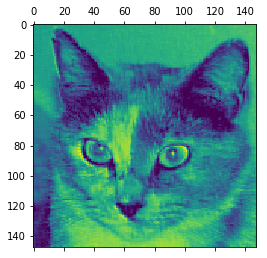

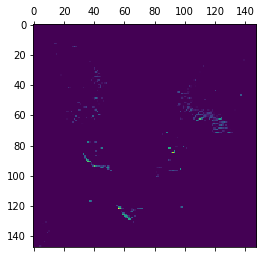

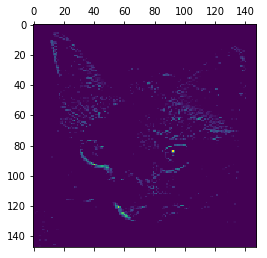

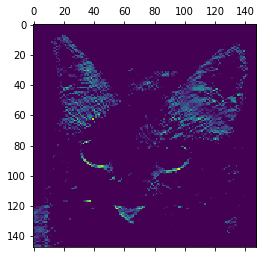

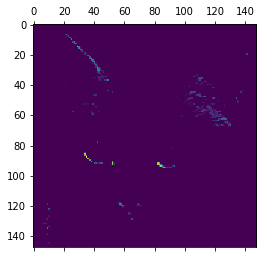

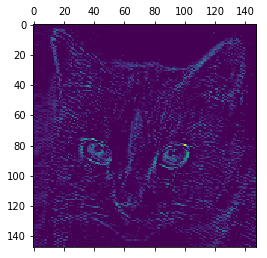

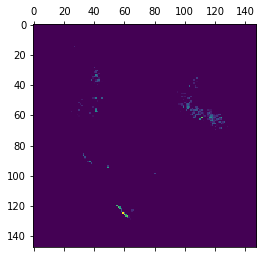

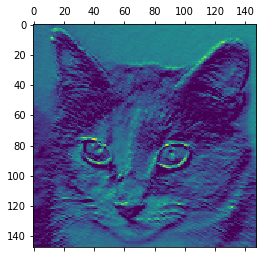

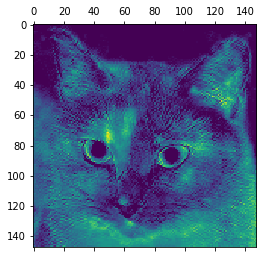

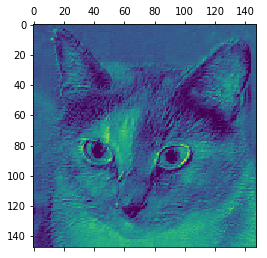

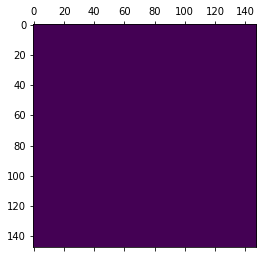

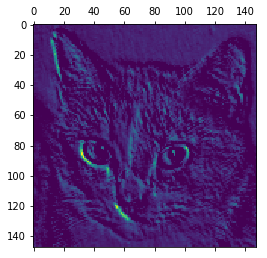

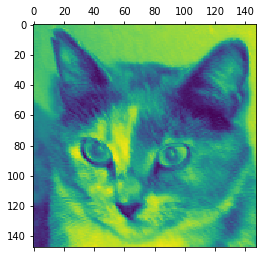

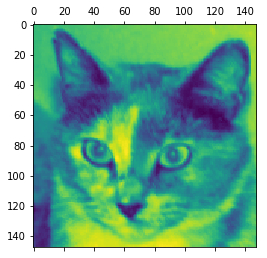

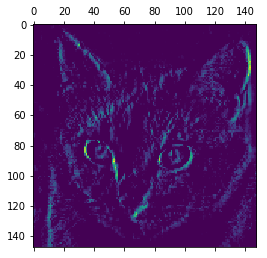

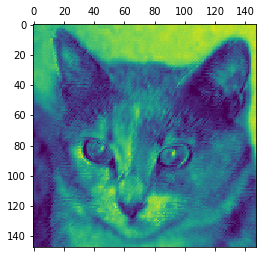

In [34]:
import matplotlib.pyplot as plt

for i in range(first_layer_activation.shape[3]):
    plt.matshow(first_layer_activation[0, :, :, i], cmap='viridis')
    plt.show()

c:\users\manny\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


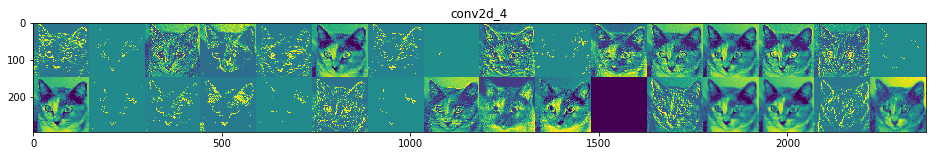

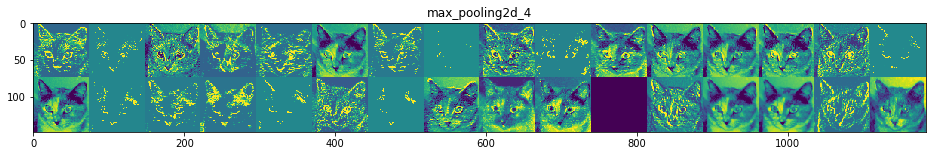

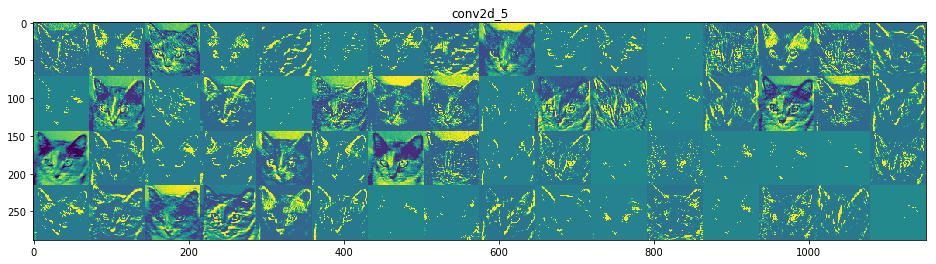

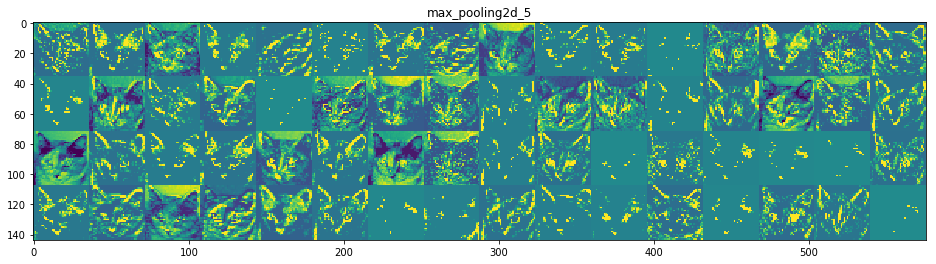

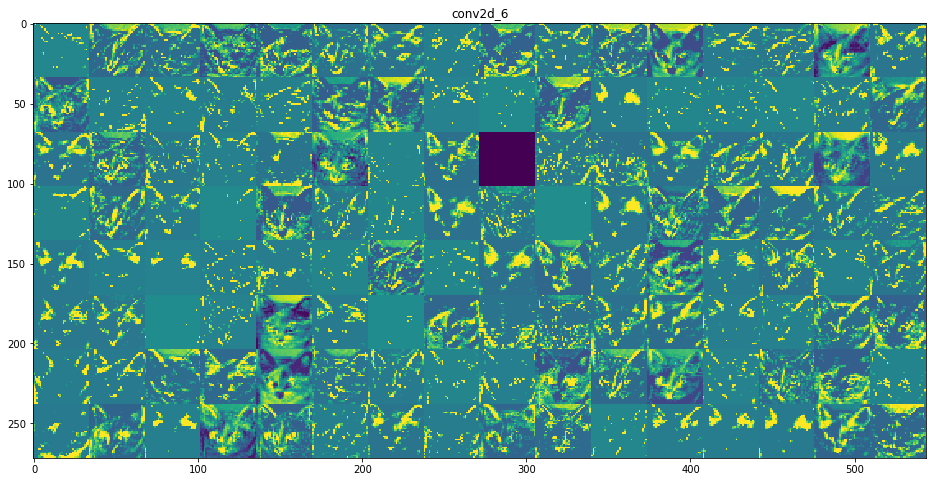

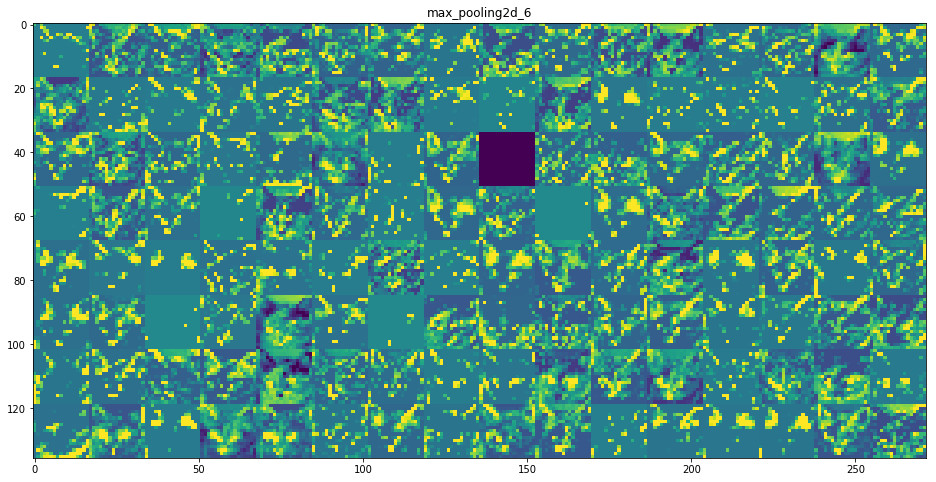

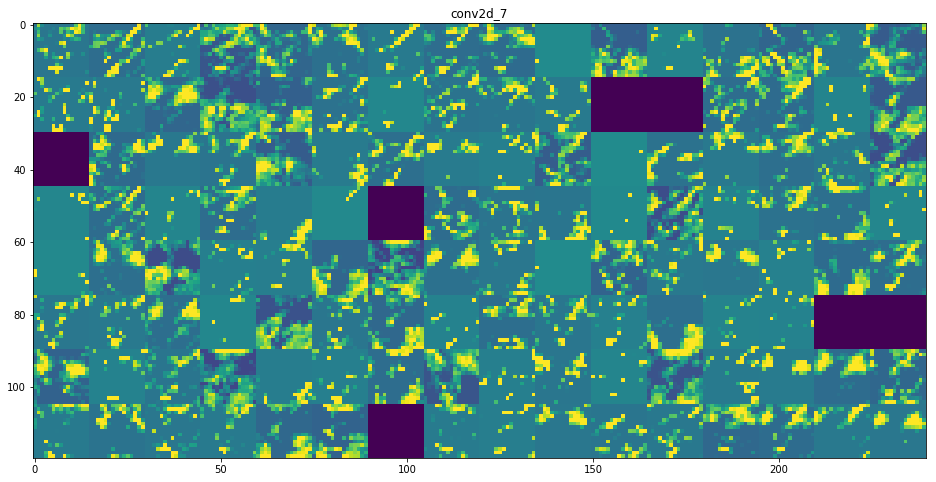

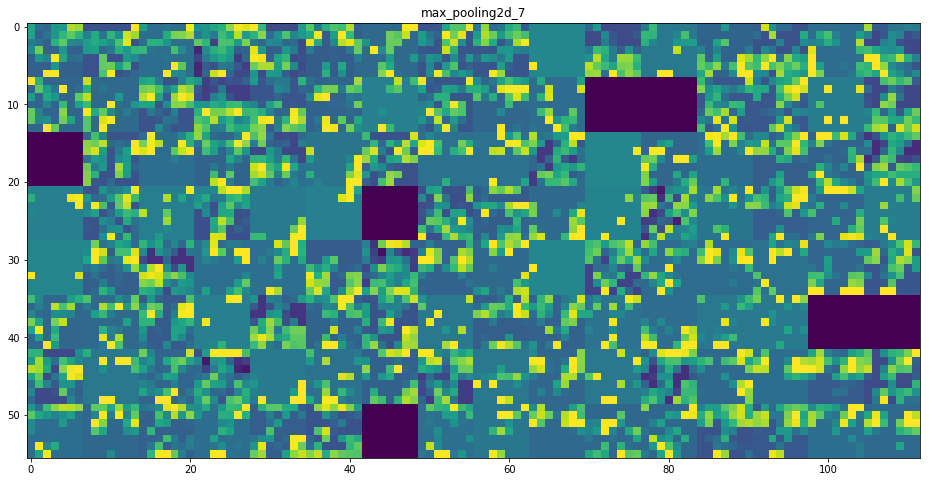

In [35]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]

    size = layer_activation.shape[1]

    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

In [36]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',
              include_top=False)

In [37]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [38]:
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    iterate = K.function([model.input], [loss, grads])
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

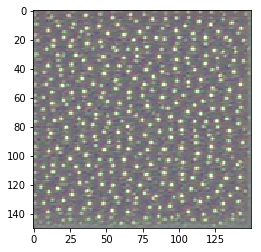

In [39]:
plt.imshow(generate_pattern('block3_conv1', 0))
plt.show()

block1_conv1


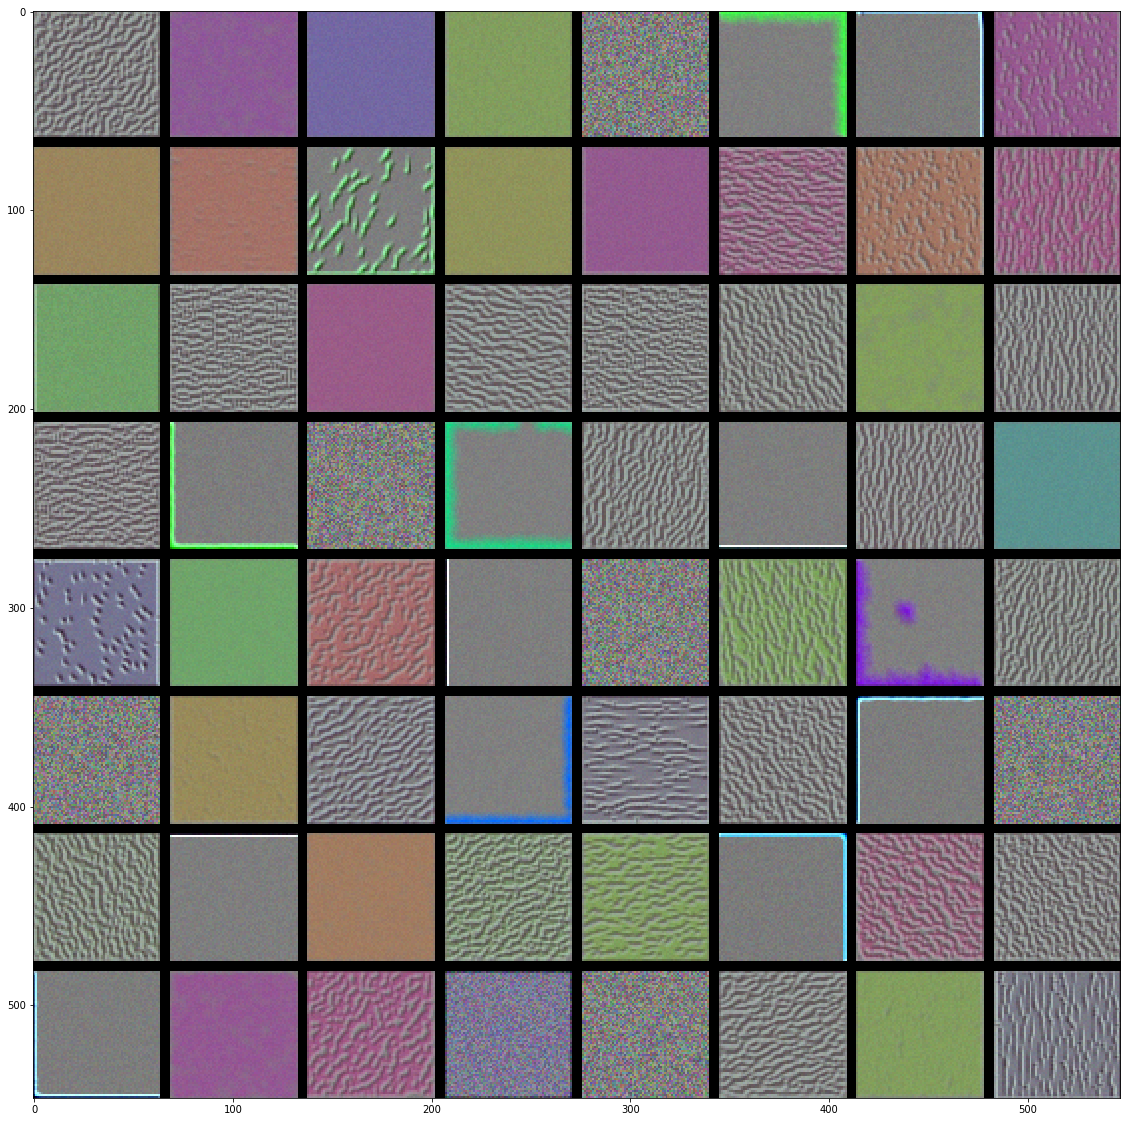

block2_conv1


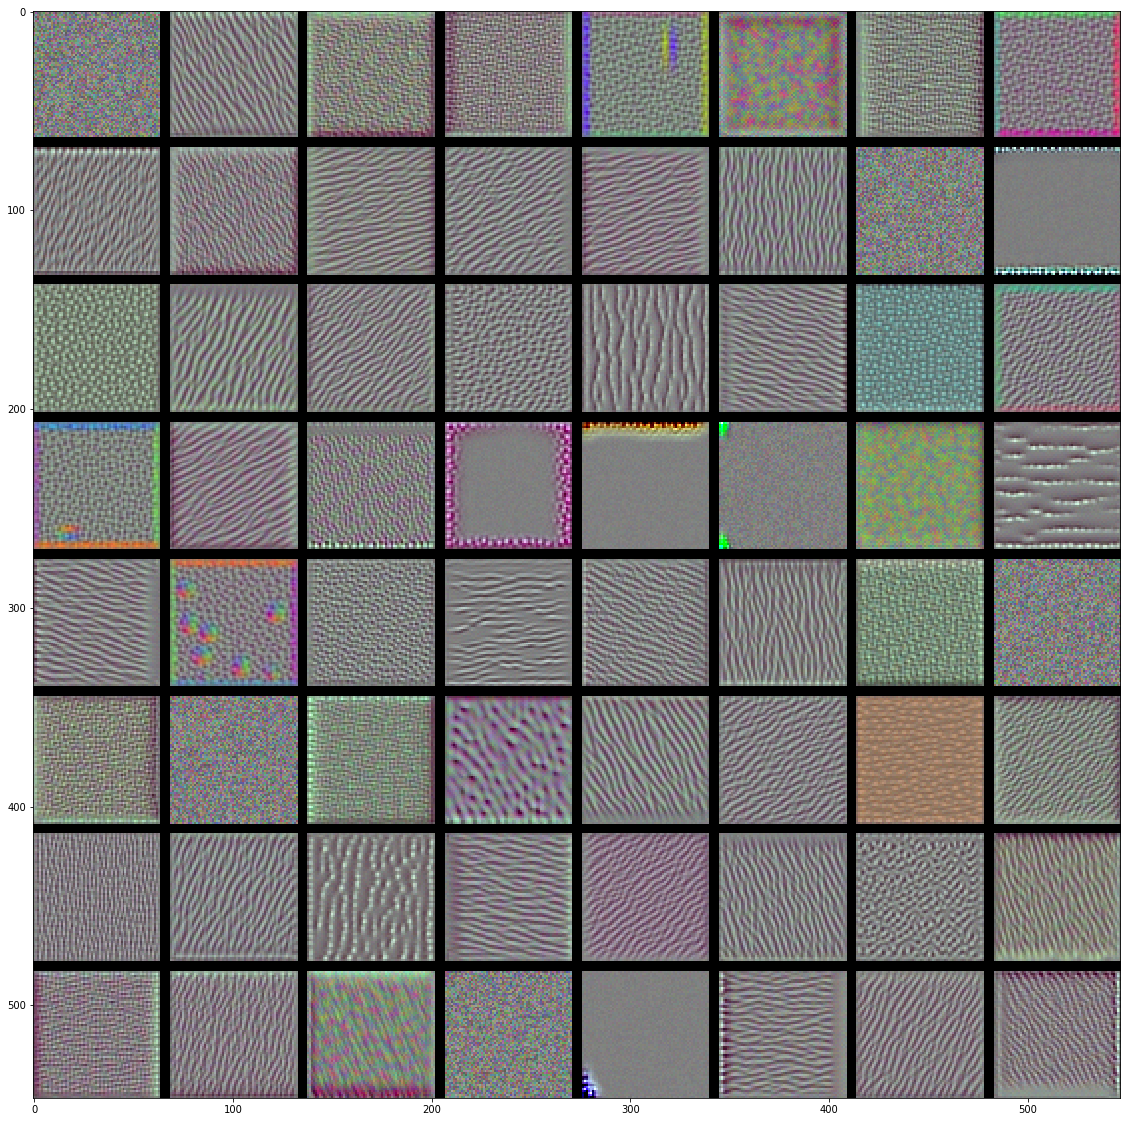

block3_conv1


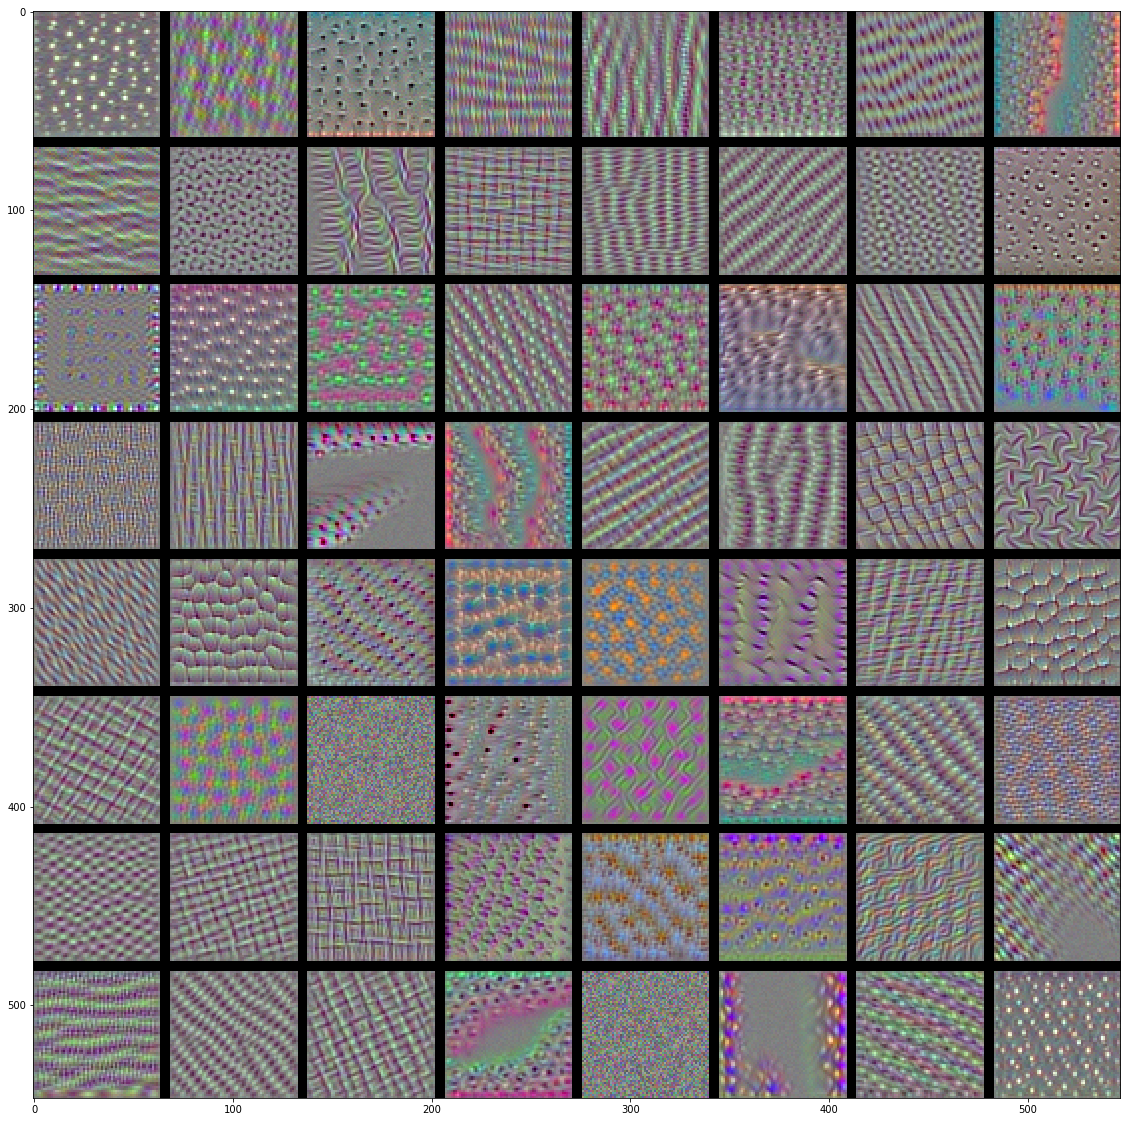

block4_conv1


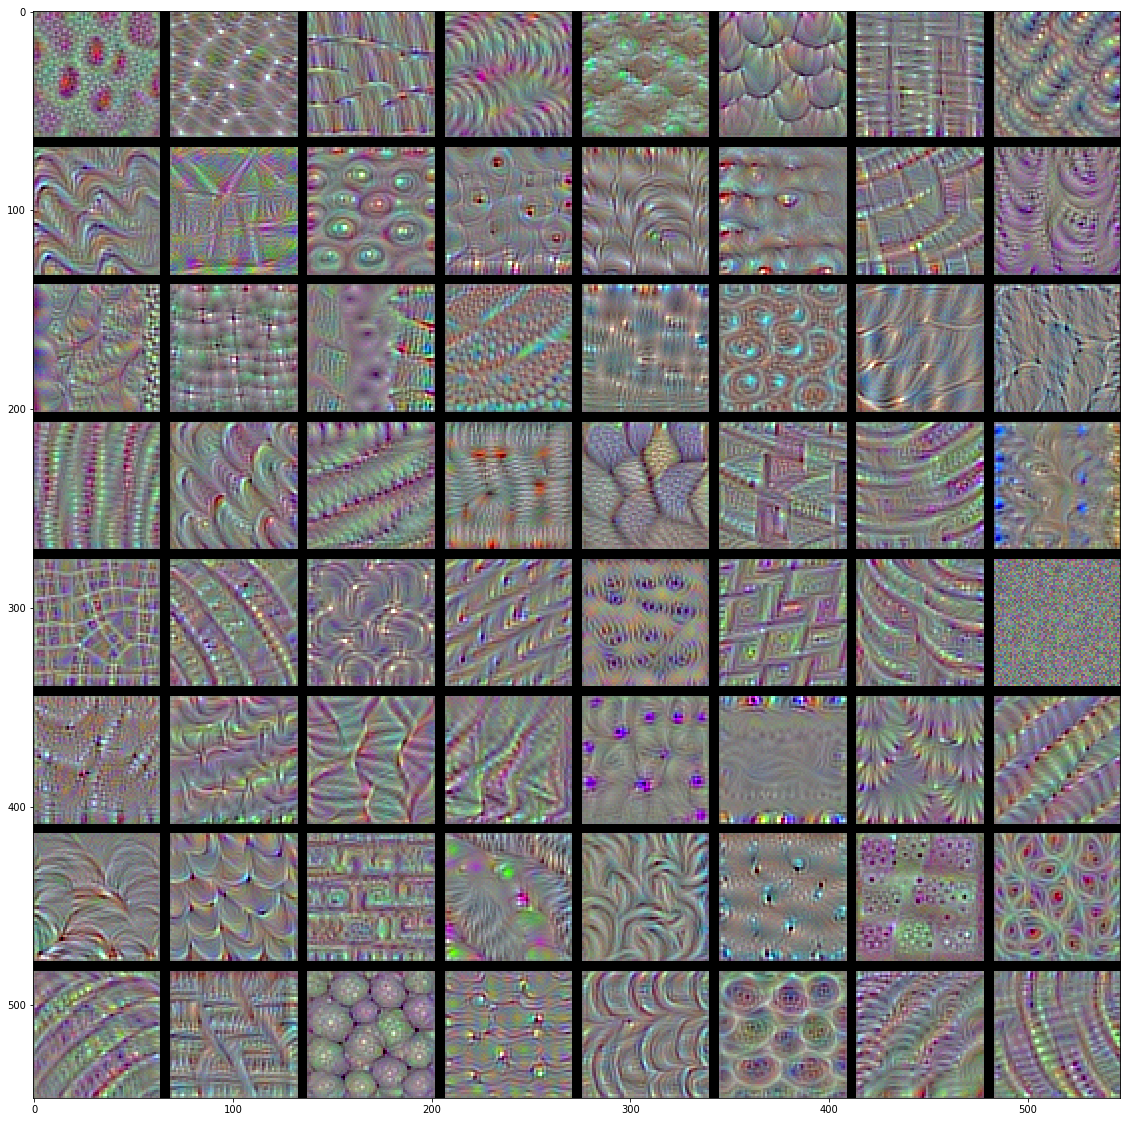

block5_conv1


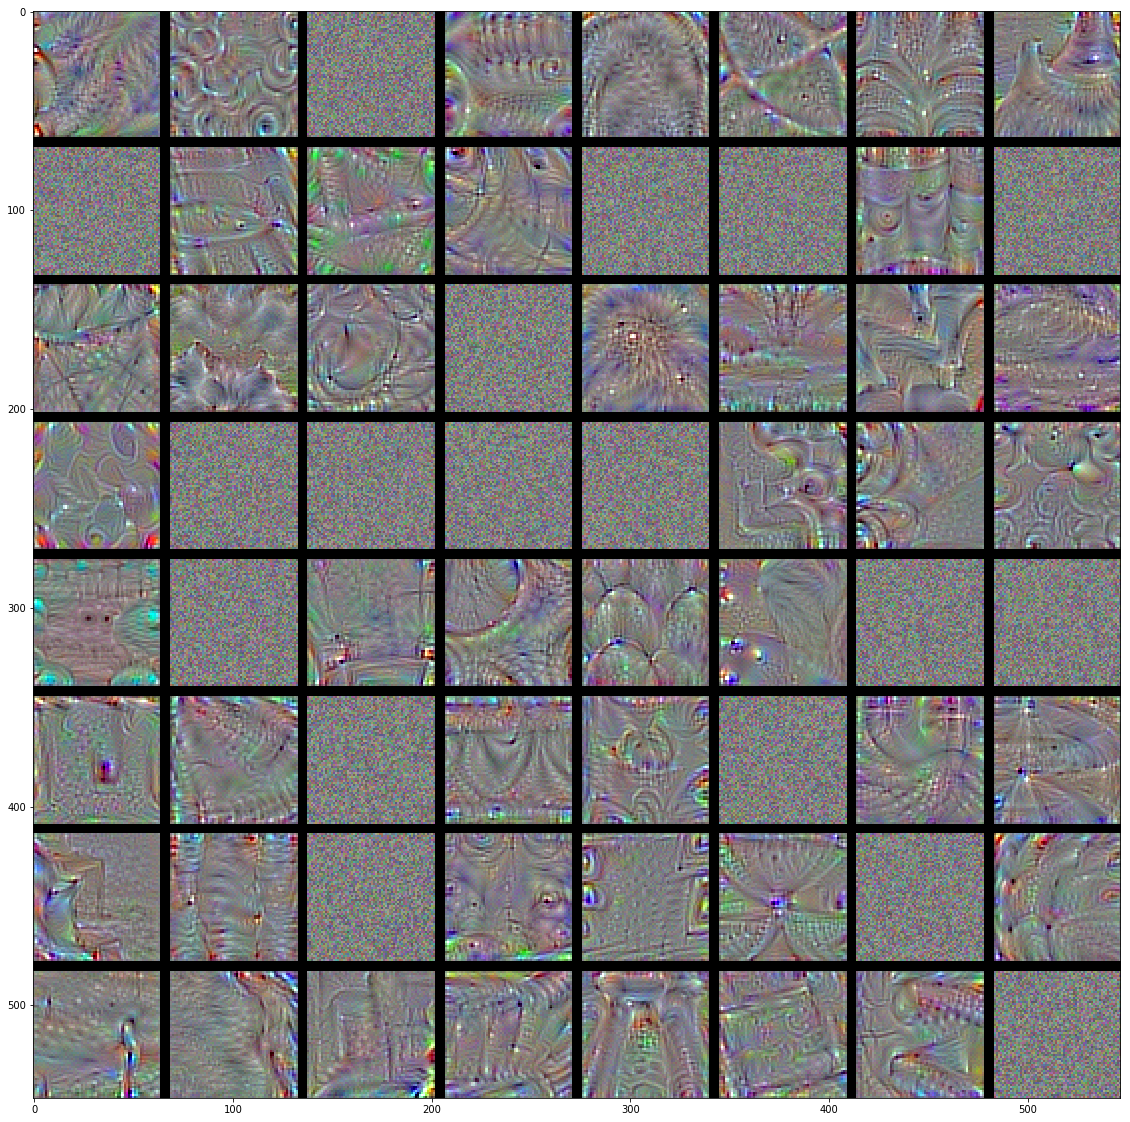

In [40]:
for layer_name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']:
    size = 64
    margin = 5
    print(layer_name)

    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    for i in range(8):
        for j in range(8):
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
            filter_img = filter_img.astype('float32') / 255

            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.show()

In [41]:
from keras.applications.vgg16 import VGG16

K.clear_session()
model = VGG16(weights='imagenet')

In [42]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = './CC_Elephant/creative_commons_elephant.jpg'
img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [43]:
preds = model.predict(x)

print('Predicted:')
for p in decode_predictions(preds, top=3)[0]:
    print(p)

Predicted:
('n02504458', 'African_elephant', 0.9094213)
('n01871265', 'tusker', 0.08618258)
('n02504013', 'Indian_elephant', 0.004354575)


In [44]:
np.argmax(preds[0])

386

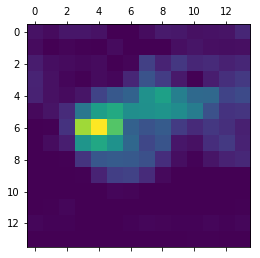

In [45]:
african_elephant_output = model.output[:, 386]
last_conv_layer = model.get_layer('block5_conv3')

grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [46]:
import cv2

# We use cv2 to load the original image
img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

# Save the image to disk
cv2.imwrite('./CC_Elephant/elephant_cam.jpg', superimposed_img)

True

![Elephant heatmap](./CC_Elephant/creative_commons_elephant.jpg)

![Elephant heatmap](./CC_Elephant/elephant_cam.jpg)